In [2]:

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def gen_curve(offset, scale, noise=200, decay=False):
    base = scale * (1 - np.exp(-timesteps / 4e4)) + offset
    if decay:
        base *= (1 - 0.1 * np.sin(timesteps / 2e4))
    return base + np.random.normal(0, noise, size=timesteps.shape)


def compressor(run, sens=15, episodes=60):
    run_copy = np.copy(run)
    for _ in range(episodes):
        for i in range(1, run_copy.shape[0]-1):
            min_val = min(run_copy[i-1],run_copy[i+1])
            #max_val = max(run[i-1],run[i+1])
            if run_copy[i] <= min_val*sens:
                run_copy[i] = np.mean([run_copy[i-1],run_copy[i+1]])
    return run_copy

In [2]:
# STAGE 1 

In [4]:
# === Путь к логам ===
log_4k_1 = '/home/daniil/Рабочий стол/Accelerator/RLC_RUNS/Hopper-v4/[STAGE1_POMDP_LSTM]|seed=2|AddAsc=None|AddBell=None|UseTrData=False|EvFreq=3000.0'
log_4k_2 = '/home/daniil/Рабочий стол/Accelerator/RLC_RUNS/Hopper-v4/[STAGE1_POMDP_LSTM]|seed=3|AddAsc=None|AddBell=None|UseTrData=False|EvFreq=3000.0'



# === Чтение каждого лога ===
ea_4k_1 = EventAccumulator(log_4k_1); ea_4k_1.Reload()
ea_4k_2 = EventAccumulator(log_4k_2); ea_4k_2.Reload()

# === Список тегов ===
tags = ['LSTM_Eval_reward', 'Trans_Eval_reward']

def get_vals(ea, tag):
    events = ea.Scalars(tag)
    steps = np.array([e.step for e in events])
    vals = np.array([e.value for e in events])
    return steps, vals



In [5]:
lstm_t_1, lstm_r_1 = get_vals(ea_4k_1, 'LSTM_Eval_reward')
lstm_t_2, lstm_r_2 = get_vals(ea_4k_2, 'LSTM_Eval_reward')


tr_t_1, tr_r_1 = get_vals(ea_4k_1, 'Trans_Eval_reward')
tr_t_2, tr_r_2 = get_vals(ea_4k_2, 'Trans_Eval_reward')

In [6]:
lstm_r_1.shape , lstm_r_2.shape, tr_r_1.shape, tr_r_2.shape

((158,), (158,), (158,), (158,))

In [7]:
lstm_mean = (lstm_r_1[:] + lstm_r_2[:]) / 2
lstm_std = np.abs(lstm_r_1[:] - lstm_r_2[:]) / 2

tr_mean = (tr_r_1[:] + tr_r_2[:]) / 2
tr_std = np.abs(tr_r_1[:] - tr_r_2[:]) / 2

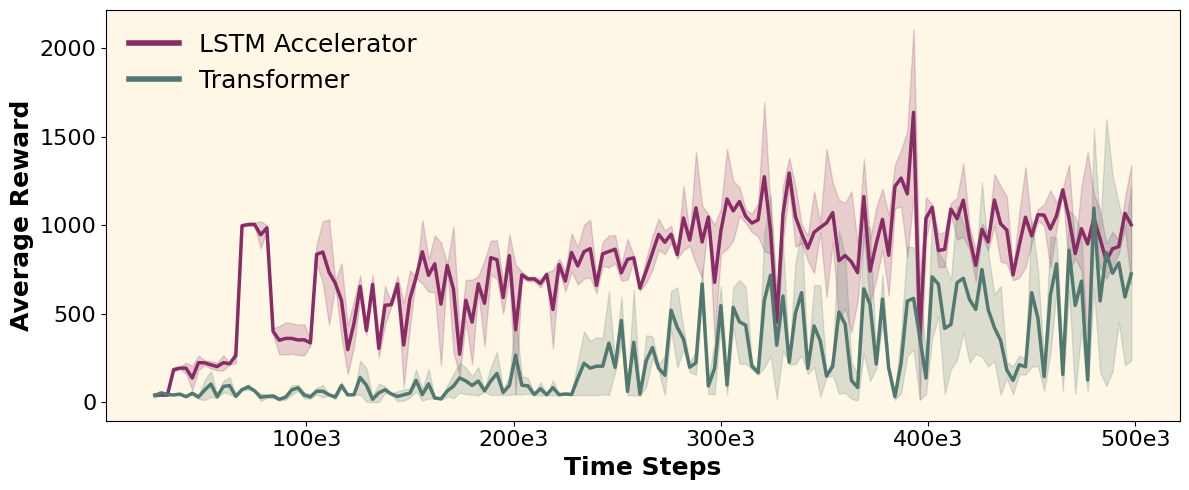

In [9]:
# ========= Отрисовка графика ============
fig, ax = plt.subplots(figsize=(12, 5))
fig.patch.set_facecolor('white')
ax.set_facecolor('#fff7e6')

# MDP_PRETRAINED (сплошные линии)
line1, = ax.plot(lstm_t_1[:], lstm_mean, label='LSTM Accelerator', color='#892b64', linewidth=2.5)
ax.fill_between(lstm_t_1[:], lstm_mean - lstm_std, lstm_mean + lstm_std, color='#892b64', alpha=0.2)

line2, = ax.plot(lstm_t_1[:], tr_mean, label='Transformer', color='#52796f', linewidth=2.5)
ax.fill_between(lstm_t_1[:], tr_mean - tr_std, tr_mean + tr_std, color='#52796f', alpha=0.2)

# ===== Оформление графика =====
ax.set_xlabel("Time Steps", fontsize=18, weight='bold')
ax.set_ylabel("Average Reward", fontsize=18, weight='bold')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x/1e3)}e3"))

# Легенда без рамки, с увеличенным шрифтом и жирными линиями
legend = ax.legend(
    handles=[
        plt.Line2D([0], [0], color='#892b64', linewidth=4, label='LSTM Accelerator'),
        plt.Line2D([0], [0], color='#52796f', linewidth=4, label='Transformer')
    ],
    loc='upper left',
    fontsize=18,
    frameon=True
)
legend.get_frame().set_facecolor('#fff7e6')
legend.get_frame().set_edgecolor('#fff7e6')  # Цвет рамки как у фона, чтобы была "невидимой"

plt.tight_layout()
plt.show()

# STAGE 2

In [5]:
# === Путь к логам ===
tr1 = '/home/daniil/Рабочий стол/Accelerator/RLC_RUNS/Hopper-v4/[STAGE2_POMDP_LSTM]|seed=3|AddAsc=None|AddBell=None|UseTrData=False|EvFreq=10000'
tr2 = '/home/daniil/Рабочий стол/Accelerator/RLC_RUNS/Hopper-v4/[STAGE2_POMDP_LSTM]|seed=2|AddAsc=None|AddBell=None|UseTrData=False|EvFreq=10000'

lstm1 = '/home/daniil/Рабочий стол/Accelerator/RLC_RUNS/Hopper-v4/[STAGE1_POMDP_LSTM]|seed=2|AddAsc=None|AddBell=None|UseTrData=False|EvFreq=3000.0'
lstm2 = '/home/daniil/Рабочий стол/Accelerator/RLC_RUNS/Hopper-v4/[STAGE1_POMDP_LSTM]|seed=3|AddAsc=None|AddBell=None|UseTrData=False|EvFreq=3000.0'

mlp1 = 'FIG4_RUNS[FINAL_MLP_POMDP]/Hopper-v4/seed=3'
mlp2 = 'FIG4_RUNS[FINAL_MLP_POMDP]/Hopper-v4/seed=2'

# === Чтение каждого лога ===
tr1 = EventAccumulator(tr1); tr1.Reload()
tr2 = EventAccumulator(tr2); tr2.Reload()

lstm1 = EventAccumulator(lstm1); lstm1.Reload()
lstm2 = EventAccumulator(lstm2); lstm2.Reload()

mlp1 = EventAccumulator(mlp1); mlp1.Reload()
mlp2 = EventAccumulator(mlp2); mlp2.Reload()
# === Список тегов ===
tags1 = ['Eval_reward']
tags2 = ['LSTM_Eval_reward']

def get_vals(ea, tag):
    events = ea.Scalars(tag)
    steps = np.array([e.step for e in events])
    vals = np.array([e.value for e in events])
    return steps, vals


# STAGE 2

In [8]:

tr1_s, tr1_v = get_vals(tr1, 'Eval_reward')
tr2_s, tr2_v = get_vals(tr2, 'Eval_reward')

lstm1_s, lstm1_v = get_vals(lstm1, 'LSTM_Eval_reward')
lstm2_s, lstm2_v = get_vals(lstm2, 'LSTM_Eval_reward')

mlp1_s, mlp1_v = get_vals(mlp1, 'Eval_reward')
mlp2_s, mlp2_v = get_vals(mlp2, 'Eval_reward')

In [9]:
tr1_v.shape, tr2_v.shape,      lstm1_v.shape, lstm2_v.shape,         mlp1_v.shape, mlp2_v.shape, 

((54,), (52,), (158,), (158,), (158,), (158,))

In [10]:
cutout = 52

mean_tr = (tr1_v[:cutout] + tr2_v[:cutout]) / 2
std_tr  = np.abs(tr1_v[:cutout] - tr2_v[:cutout]) / 2

mean_lstm = (lstm1_v[:cutout] + lstm2_v[:cutout]) / 2
std_lstm = np.abs(lstm1_v[:cutout] - lstm2_v[:cutout]) / 2

mean_mlp = (mlp1_v[:cutout] + mlp2_v[:cutout]) / 2
std_mlp  = np.abs(mlp1_v[:cutout] - mlp2_v[:cutout]) / 2

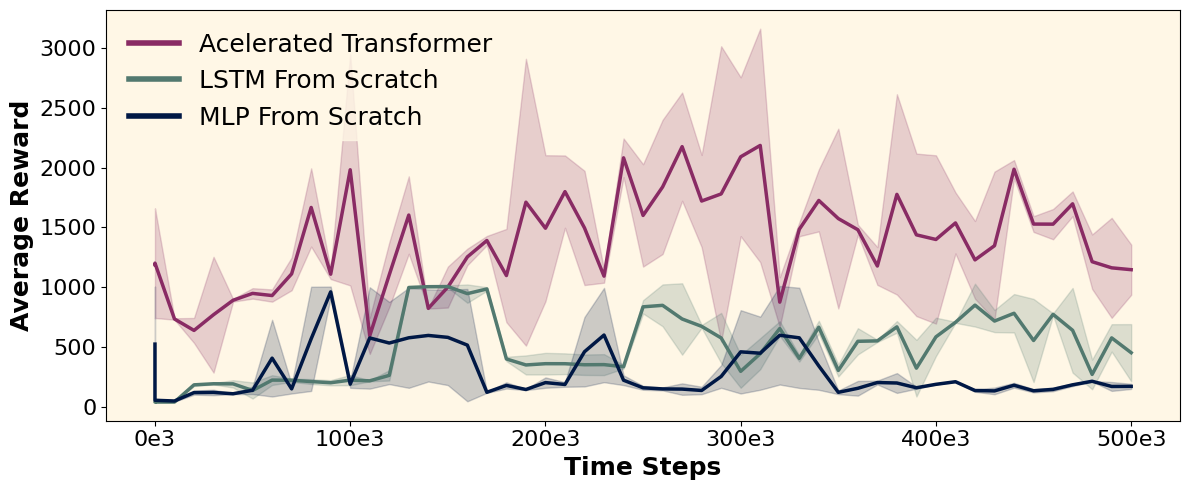

In [12]:
# ========= Отрисовка графика ============
fig, ax = plt.subplots(figsize=(12, 5))
fig.patch.set_facecolor('white')
ax.set_facecolor('#fff7e6')

# MDP_PRETRAINED (сплошные линии)
line1, = ax.plot(tr2_s, mean_tr, label='Acelerated Transformer', color='#892b64', linewidth=2.5)
ax.fill_between(tr2_s, mean_tr - std_tr, mean_tr + std_tr, color='#892b64', alpha=0.2)

line2, = ax.plot(tr2_s, mean_lstm, label='LSTM From Scratch', color='#52796f', linewidth=2.5)
ax.fill_between(tr2_s, mean_lstm - std_lstm, mean_lstm + std_lstm, color='#52796f', alpha=0.2)

line2, = ax.plot(tr2_s, mean_mlp, label='MLP From Scratch', color='#001845', linewidth=2.5)
ax.fill_between(tr2_s, mean_mlp - std_mlp, mean_mlp + std_mlp, color='#001845', alpha=0.2)


# ===== Оформление графика =====
ax.set_xlabel("Time Steps", fontsize=18, weight='bold')
ax.set_ylabel("Average Reward", fontsize=18, weight='bold')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x/1e3)}e3"))

# Легенда без рамки, с увеличенным шрифтом и жирными линиями
legend = ax.legend(
    handles=[
        plt.Line2D([0], [0], color='#892b64', linewidth=4, label='Acelerated Transformer'),
        plt.Line2D([0], [0], color='#52796f', linewidth=4, label='LSTM From Scratch'),
        plt.Line2D([0], [0], color='#001845', linewidth=4, label='MLP From Scratch')
    ],
    loc='upper left',
    fontsize=18,
    frameon=True
)
legend.get_frame().set_facecolor('#fff7e6')
legend.get_frame().set_edgecolor('#fff7e6')  # Цвет рамки как у фона, чтобы была "невидимой"

plt.tight_layout()
plt.show()